In [6]:
import pandas as pd

file = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/machine_learning/Supervised/tri_q4_scaled.xlsx'
df = pd.read_excel(file)

negative_ee_df = df[df['Scaled ee'] < 0][['Reactant ID', 'Catalyst ID']]

negative_ee_df

,Reactant ID,Catalyst ID
65,react_1672,cat_214
93,react_899,cat_410
139,react_362,cat_894
158,react_327,cat_940
173,react_1186,cat_940
174,react_330,cat_940
194,react_672,cat_1207
213,react_627,cat_1207
224,react_1353,cat_1207
232,react_1971,cat_1231


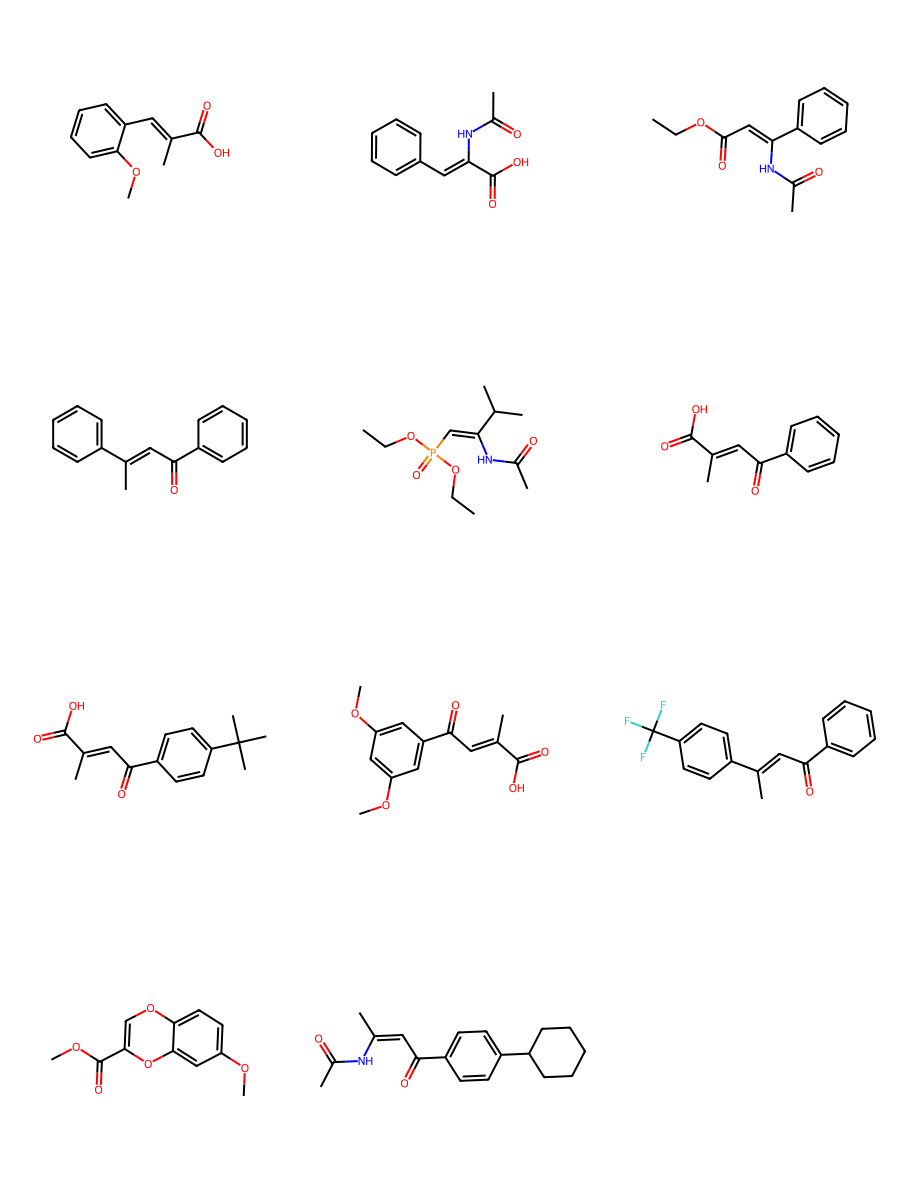

In [38]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

file_path_react_map = '/Users/zhangjiayi/Desktop/Chem Research/molli/Practice/alkene/fixed_react_map_aho_dataset.xlsx'
react_map_df = pd.read_excel(file_path_react_map)
specific_reactant_ids = [
    'react_1672', 'react_899', 'react_362', 'react_327', 'react_1186', 
    'react_330', 'react_672', 'react_627', 'react_1353', 'react_1971', 'react_917'
]
specific_catalyst_ids = [
    'cat_214', 'cat_410', 'cat_894', 'cat_940', 'cat_1207', 'cat_1231', 'cat_1674'
]

filtered_reactants = react_map_df[react_map_df['Reactant ID'].isin(specific_reactant_ids)][['Reactant ID', 'Reactant SMILES']].drop_duplicates(subset='Reactant SMILES')
reactant_mols = [Chem.MolFromSmiles(smiles) for smiles in filtered_reactants['Reactant SMILES'] if Chem.MolFromSmiles(smiles)]

filtered_catalysts = react_map_df[react_map_df['Catalyst ID'].isin(specific_catalyst_ids)][['Catalyst ID', 'Catalyst SMILES(RDKit)']].drop_duplicates(subset='Catalyst SMILES(RDKit)')
catalyst_mols = [Chem.MolFromSmiles(smiles) for smiles in filtered_catalysts['Catalyst SMILES(RDKit)'] if Chem.MolFromSmiles(smiles)]

reactant_images = None
catalyst_images = None

if reactant_mols:
    reactant_images = Draw.MolsToGridImage(reactant_mols, molsPerRow=3, subImgSize=(300, 300))

if catalyst_mols:
    catalyst_images = Draw.MolsToGridImage(catalyst_mols, molsPerRow=3, subImgSize=(300, 300))

reactant_images

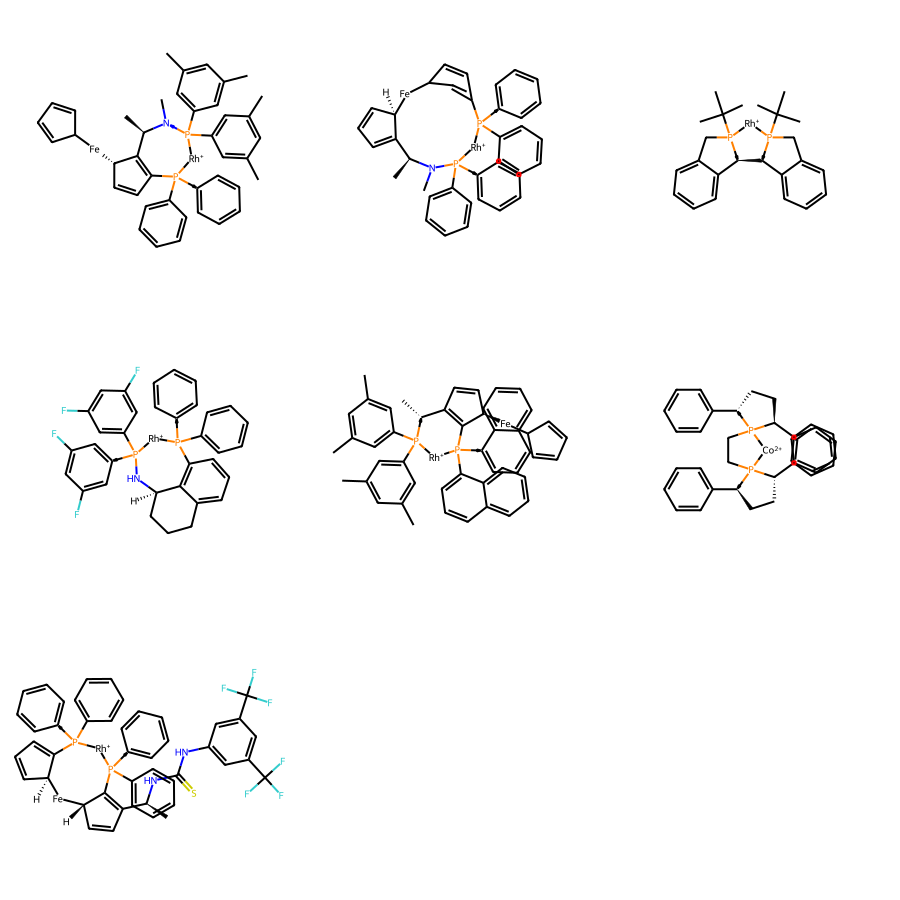

In [39]:
catalyst_images

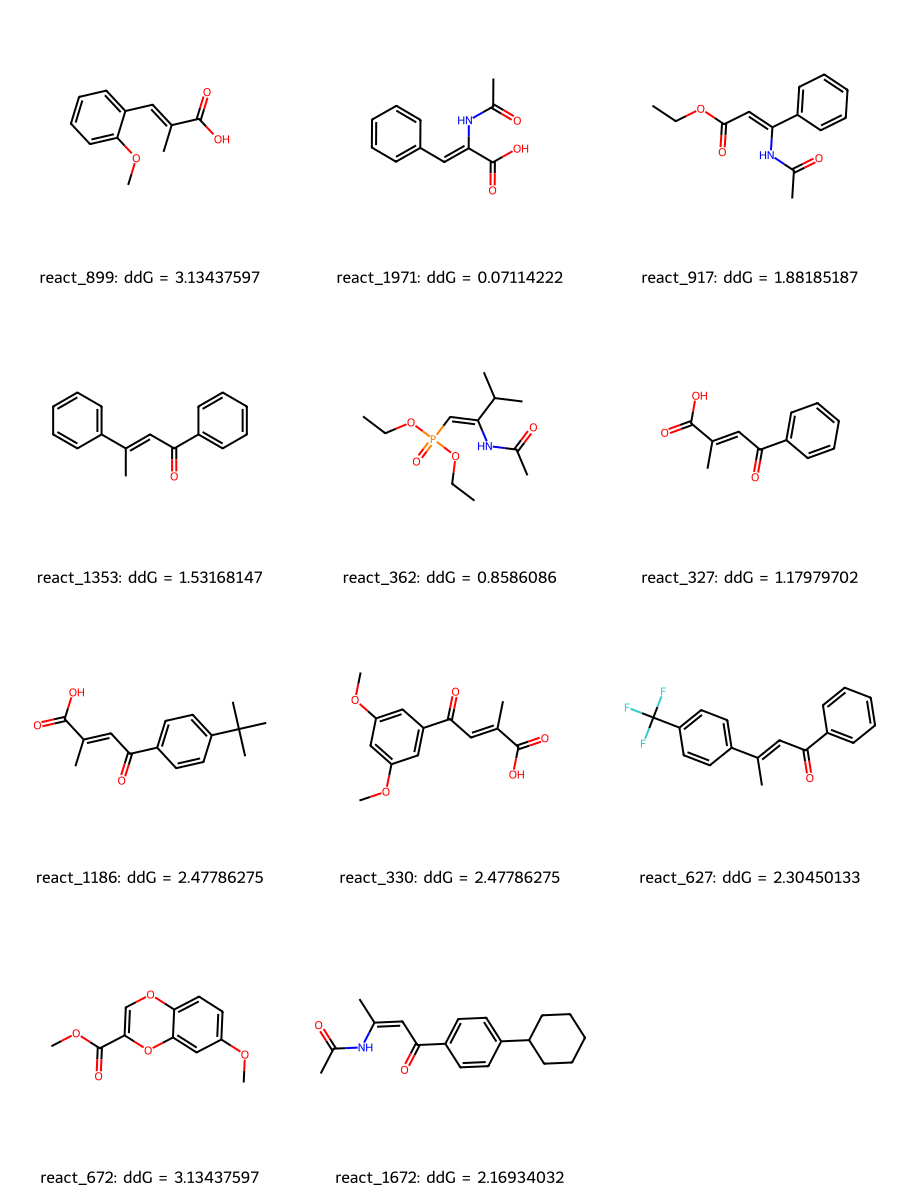

In [43]:
filtered_reactants = react_map_df[react_map_df['Reactant ID'].isin(specific_reactant_ids)][['Reactant ID', 'Reactant SMILES', 'ddG']].drop_duplicates(subset='Reactant SMILES')

# Generate RDKit molecule objects
mols = [Chem.MolFromSmiles(smiles) for smiles in filtered_reactants['Reactant SMILES'] if Chem.MolFromSmiles(smiles)]
legends = [f"{row['Reactant ID']}: ddG = {row['ddG']}" for _, row in filtered_reactants.iterrows()]

Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)


In [46]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw
import pandas as pd

# Function to add highlight to preferred enantiomer
def highlight_preferred(image, is_preferred):
    img = image.convert("RGB")
    draw = ImageDraw.Draw(img)
    if is_preferred:
        draw.rectangle([0, 0, img.width - 1, img.height - 1], outline="green", width=5)
    else:
        draw.rectangle([0, 0, img.width - 1, img.height - 1], outline="red", width=2)
    return img

# Sample dataset based on your data
data = {
    'Reactant ID': ['react_1672', 'react_899', 'react_362', 'react_327', 'react_1186', 
                    'react_330', 'react_672', 'react_627', 'react_1353', 'react_1971', 'react_917'],
    'Reactant SMILES': [
        'CC(C)C(=O)O',  # Replace these placeholder SMILES with actual data values
        'CC(C)C(=O)N', 
        'CC(C)C(=O)OC',
        'CC(C)(C(=O)O)N',
        'CC(C)(C(=O)O)OC',
        'CC(C)C(=O)F',
        'CC(C)(C(=O)Cl)OC',
        'CC(C)(C(=O)Br)N',
        'CC(C)C(=O)OCC',
        'CC(C)(C(=O)Cl)O',
        'CC(C)C(=O)OBr'
    ],
    'ddG': [-5.4, 2.3, -1.8, -0.5, 3.0, -2.1, 1.2, -3.7, 0.6, -1.9, 4.0]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Generate both R and S enantiomers for each reactant
enantiomers = []
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row['Reactant SMILES'])
    if mol is not None:
        Chem.AssignStereochemistry(mol, cleanIt=True, force=True)
        
        # Set R configuration
        mol_r = Chem.Mol(mol)
        mol_r.GetAtomWithIdx(1).SetChiralTag(Chem.CHI_TETRAHEDRAL_CW)
        smi_r = Chem.MolToSmiles(mol_r, isomericSmiles=True)
        enantiomers.append((row['Reactant ID'], smi_r, row['ddG'], 'R', row['ddG'] < 0))
        
        # Set S configuration
        mol_s = Chem.Mol(mol)
        mol_s.GetAtomWithIdx(1).SetChiralTag(Chem.CHI_TETRAHEDRAL_CCW)
        smi_s = Chem.MolToSmiles(mol_s, isomericSmiles=True)
        enantiomers.append((row['Reactant ID'], smi_s, row['ddG'], 'S', row['ddG'] < 0))

# Convert to DataFrame
enantiomers_df = pd.DataFrame(enantiomers, columns=['Reactant ID', 'Enantiomer SMILES', 'ddG', 'Configuration', 'Preferred'])

# Generate RDKit molecule objects, draw each, and apply highlighting based on preference
mols = [Chem.MolFromSmiles(smiles) for smiles in enantiomers_df['Enantiomer SMILES']]
highlighted_images = []
for mol, (idx, row) in zip(mols, enantiomers_df.iterrows()):
    # Draw molecule image with legend
    img = Draw.MolToImage(mol, size=(300, 300), legend=f"{row['Reactant ID']} ({row['Configuration']}): ddG = {row['ddG']}")
    # Highlight preferred enantiomer
    highlighted_images.append(highlight_preferred(img, row['Preferred']))

# Combine all highlighted images into a single grid
grid_image = Image.new('RGB', (900, (len(highlighted_images) // 3 + 1) * 300))
for i, img in enumerate(highlighted_images):
    grid_image.paste(img, (300 * (i % 3), 300 * (i // 3)))

# Display the final grid image
grid_image.show()
